In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict,cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import optuna


In [2]:
filepath = r"C:\Users\lucap\OneDrive\Desktop\PhD\Racheal\Dati\dataset_clean.csv"
df = pd.read_csv(filepath, sep = ";" )

In [3]:
diz_aliases_int_voto = {"Partito Democratico-PD":'Sx/CSx',
                "Partito Democratico":'Sx/CSx',
                "Lega con Salvini":'Dx/CDx',
                "Lega Nord":'Dx/CDx',
                "Lega":'Dx/CDx',
                "Forza Italia":'Dx/CDx',
                "Fratelli d'Italia":"Dx/CDx",
                'MoVimento 5 Stelle':'M5S',
                'Movimento 5 stelle':'M5S',
                'voterei  scheda bianca / annullerei la scheda':'astensione/bianca/nulla',
                'voterei scheda bianca / scheda nulla':'astensione/bianca/nulla',
                "+Europa":'Sx/CSx',
                "piu' Europa con Emma Bonino": "Sx/CSx",
                'Sinistra italiana (SEL + altri)':'Sx/CSx',
                'Potere al Popolo':'Sx/CSx',
                'Rifondazione Comunista':'Sx/CSx',
                "Fratelli d'Italia-Alleanza Nazionale&nbsp;":"Dx/CDx",
                'La Sinistra':'Sx/CSx',
                'Verdi':'Sx/CSx',
                'non andrei a votare':'astensione/bianca/nulla',
                'sono indeciso' : 'indecisi',
                'Liberi e Uguali' : 'Sx/CSx',
                'Italia dei Valori' : 'Sx/CSx',
                'Scelta Civica&nbsp;' : 'Sx/CSx',
                'Italia Unica di Corrado Passera' : 'Sx/CSx',
                "Noi con l'Italia UDC&nbsp;" : 'Dx/CDx',
                "altro partito di area di governo (SVP, Centro Democratico....)" : 'Altro partito',
                "Nuovo Centro Destra con UDC e PPI" : 'Dx/CDx'
                }

df['m_p_int_voto'] = df['m_p_int_voto'].replace(diz_aliases_int_voto)
df = df[~df['m_p_int_voto'].isin(['Altro partito', 'preferisco non rispondere', 'indecisi','astensione/bianca/nulla' ])]
df['m_p_int_voto'].value_counts()

m_p_int_voto
Sx/CSx    1348
Dx/CDx    1102
M5S        869
Name: count, dtype: int64

In [4]:
diz_aliases_ac = {"del tutto d'accordo":2,
            "del tutto<BR>d'accordo":2,
		     "d'accordo":1,
		     "ne' d'accordo ne' in disaccordo (NON STIMOLARE)":0,
             "ne d'accordo ne' in disaccordo":0,
             "ne' d'accordo ne' in disaccordo":0,
             "preferisco non rispondere":0,
             "preferisco<BR>non<BR> rispondere":0,
            "non saprei":0,
             "in disaccordo":-1,
             'del tutto in disaccordo':-2,
             "del tutto disaccordo":-2,
             "del tutto<BR>in disaccordo":-2,
             
            
}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if '_ac_' in var:
        df[var] = df[var].replace(diz_aliases_ac)
        
        
diz_aliases_op = {"molto":2,
            "poco":-1,
            "pocao":-1,
		     "abbastanza":1,
		     "non saprei":0,
            "nessuno":-2,
            "per niente":-2}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'op' in var:
        df[var] = df[var].replace(diz_aliases_op)
        

diz_aliases_trend = {"in trend":1,
                 "slight in trend":1,
                 "slight off trend":0,
                 "off trend":0,
                 'non classificati':0}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'TREND' in var:
        df[var] = df[var].replace(diz_aliases_trend)
        
        
diz_aliases_scol = {"elementare/privo di titolo":1,
                 "media inferiore":1,
                 "diploma di maturita` (5 anni)":2,
                 "superiori in corso":2,
                 'diploma di istituto professionale (3 anni)':2,
                 'universita` in corso/nessuna laurea conseguita':4,
                 'laurea triennale di I livello':4,
                 'diploma universitario/laurea breve':4,
                 'laurea specialistica di II livello o laurea 4-5 anni':4,
                 'master/scuola di specializzazione post laurea':4,
                 'dottorato di ricerca':4
                 }
 
df['m_p_scolarita'] = df['m_p_scolarita'].replace(diz_aliases_scol)



diz_aliases_geo = {'meno di 5.000':1,
                 'da 5.001 a 10.000':1,
                 'da 10.001 a 30.000':2,
                 'da 30.001 a 100.000':2,
                 'da 100.001 a 250.000':3,
                 'piu` di 250.001':3
                 }
 
df['m_p_r_ampiezza6'] = df['m_p_r_ampiezza6'].replace(diz_aliases_geo)

diz_aliases_eco = {
                 "mi sento povero e non arrivo mai a fine mese":-1,
                 "avverto difficolta'":-1,
                 "arrivo a fine mese con molte difficolta'":-1,
                 "con tranquillita'":1,
                 'agiatamente':1
                 }
 
df['m_op_come_reddito_consenteDiVivere'] = df['m_op_come_reddito_consenteDiVivere'].replace(diz_aliases_eco)


df = pd.get_dummies(df, columns=['m_op_preferenza_lavorativa'], prefix='prf_lav',dtype=int)

#df = pd.get_dummies(df, columns=['m_p_zona_5istat'], prefix='zona')
df = pd.get_dummies(df, columns=['m_istat_reg'], prefix='reg',dtype=int)

diz_aliases_quot = {
                 0:0,
                 'preferisco non rispondere':0,
                 "si alcune volte alla settimana":1,
                 "si ogni giorno":1
                 }
 
df['m_p_lettura_quotidiani'] = df['m_p_lettura_quotidiani'].replace(diz_aliases_quot)

diz_aliases_freq_y = {'mai':0,
                     "piu' raramente":0,
                 "alcune volte l'anno":1,
                  "piu' volte alla settimana":2,
                 'mensile':1,
                 'settimanale':2}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_p_' in var:
        df[var] = df[var].replace(diz_aliases_freq_y)
        
        
diz_aliases_freq = {'non saprei':0,
                     "non ascolto la radio":0,
                 "da piu' di un'ora fino a due ore":1,
                  "da piu' di tre ore fino a quattro ore":2,
                 'oltre quattro':2,
                 "da piu' di due ore fino a tre ore":2,
                 "meno di un'ora":1}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_p_' in var:
        df[var] = df[var].replace(diz_aliases_freq)
        

diz_aliases_comp = {
                 0:0,
                 'inferiore':-1,
                 'uguale':0,
                 "maggiore":1,
                 'nan':0
                 }
 
df['m_op_disorientamento_realta_quotidiana_vs_3anniFa'] = df['m_op_disorientamento_realta_quotidiana_vs_3anniFa'].replace(diz_aliases_comp)


diz_aliases_situazEconomic = {
    'rimasta la stessa': 0,
    'peggiorata': -1,
    'non sa/non risponde': 0,
    'nan': 0,
    'migliorata': 1
}
df['m_op_situazEconomic_propria_ultimi10anni'] = df['m_op_situazEconomic_propria_ultimi10anni'].replace(diz_aliases_situazEconomic)


diz_aliases_futEconomic = {
    'peggiorare': -1,
    'rimanere la stessa': 0,
    'non sa/non risponde': 0,
    'nan': 0,
    'migliorare': 1
}
df['m_op_situazEconomic_futura'] = df['m_op_situazEconomic_futura'].replace(diz_aliases_futEconomic)


diz_aliases_abo = {
    'una cattiva legge': -1,
    'una legge buona ma che va cambiata': 1,
    'una buona legge': 1,
    'non saprei/preferisco non rispondere': 0,
    'nan': 0
}

df['m_op_legge_aborto_1987'] = df['m_op_legge_aborto_1987'].replace(diz_aliases_abo)


diz_aliases_eut = {
    'no': -1,
    'si': 2,
    'non sa/non risponde': 0,
    'dipende dalle condizioni':1
}

df['m_op_favore_eutanasia_a_determinate_condizioni'] = df['m_op_favore_eutanasia_a_determinate_condizioni'].replace(diz_aliases_eut)


diz_aliases_identita = {
    "piu' europeo che italiano": 2,
    'sia italiano che europeo': 1,
    'solo italiano': -2,
    "piu' italiano che europeo": -1,
    'non sa - non risponde': 0,
    'solo europeo': 2,
    'nan': 0
}
df['m_op_sentimento_italianoVSeuropeo'] = df['m_op_sentimento_italianoVSeuropeo'].replace(diz_aliases_identita)


diz_aliases_modernizzazione = {
    'si sta modernizzando': 1,
    'sta regredendo': -1,
    'non sa/non risponde': 0,
    'nan': 0
}
df['m_modernizz_vs_regress_Paese'] = df['m_modernizz_vs_regress_Paese'].replace(diz_aliases_modernizzazione)


diz_aliases_vantaggi = {
    "piu' vantaggi": 1,
    'vantaggi e svantaggi in egual misura': 0,
    "piu' svantaggi": -1,
    "ne' vantaggi ne' svantaggi": 0,
    'non sa/non risponde': 0,
    'nan': None
}
df['m_op_partecipazione_in_UE'] = df['m_op_partecipazione_in_UE'].replace(diz_aliases_vantaggi)


diz_aliases_livello = {
    'bassa': -1,
    'media': 1,
    'alta': 2,
    0: 0,
    'nan': None
}
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_op_attenzione_' in var:
        df[var] = df[var].replace(diz_aliases_livello)
        
        
diz_aliases_andamento = {
    'rimasta uguale': 0,
    'peggiorata': -1,
    'migliorata': 1,
    0: 0,
    'nan': None
}
df['m_op_scuolaPubblica_ultimiAnni'] = df['m_op_scuolaPubblica_ultimiAnni'].replace(diz_aliases_andamento)


diz_aliases_quantita = {
    1: 1,
    'poca&nbsp;': -1,
    'molta': 2,
    'nessuna': -2,
    0: 0,
    'nan': None
}
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_op_fiducia_' in var:
        df[var] = df[var].replace(diz_aliases_quantita)
        
        
diz_aliases_postoStabile = {
    "d'accordo": 1,
    'in disaccordo': -1,
    "del tutto d'accordo": 2,
    'del tutto in disaccordo': -2,
    'preferisco non rispondere': 0,
    'nan': None
}
df['m_op_rinuncie_per_postoStabile'] = df['m_op_rinuncie_per_postoStabile'].replace(diz_aliases_postoStabile)


diz_aliases_pop = {
    'molti danni': 2,
    'nessun danno': 0,
    'qualche danno': 1,
    0: 0,
    'nan': None
}
df['m_op_danni_populismo_in_italia'] = df['m_op_danni_populismo_in_italia'].replace(diz_aliases_pop)

C:\Users\lucap\AppData\Local\Temp\ipykernel_14196\2500494670.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[var] = df[var].replace(diz_aliases_ac)
C:\Users\lucap\AppData\Local\Temp\ipykernel_14196\2500494670.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[var] = df[var].replace(diz_aliases_op)
C:\Users\lucap\AppData\Local\Temp\ipykernel_14196\2500494670.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.

In [5]:
df = df.fillna(0)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('à', 'a')
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '').str.replace(' ', '_')
df.columns = df.columns.str.replace('[()\']+|,\s*', '', regex=True)
df = df.dropna()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lucap\AppData\Local\Temp\ipykernel_14196\1203080811.py:5: SyntaxWarning: invalid escape sequence '\s'
  df.columns = df.columns.str.replace('[()\']+|,\s*', '', regex=True)


In [6]:
df

,m_anno_indagine,m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_nascita_in_italia_genitori,m_p_frequenza_cinema,m_p_frequenza_teatro,m_p_frequenza_concerti,...,reg_Molise,reg_Piemonte,reg_Puglia,reg_Sardegna,reg_Sicilia,reg_Toscana,reg_Trentino_Alto_Adige,reg_Umbria,reg_Valle_Daosta,reg_Veneto
0,2017,1,62,4,1,3,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2017,1,35,4,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017,1,56,4,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,2017,0,46,4,1,3,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
6,2017,0,61,1,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,2019,1,49,2,0,3,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4499,2019,1,75,4,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4500,2019,1,72,2,0,3,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4502,2019,1,59,4,0,3,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [7]:
best_columns = ["m_anno_indagine"
   ,"m_p_r_eta"
   ,"m_p_pubblico_privato"
   ,"m_p_r_ampiezza6"
   ,"m_p_frequenza_teatro"
   ,"m_p_frequenza_concerti"
   ,"m_p_frequenza_mostre"
   ,"m_p_frequenza_palestra_sport"
   ,"m_p_radio_ore"
   ,"m_ac_privilegio_lavoratori_sett_pubblico"
   ,"m_ac_propensioneRischio_italia_vs_europa"
   ,"m_ac_importanza_partiti"
   ,"m_ac_diminuzione_ruolo_partiti"
   ,"m_ac_affidamento_pubblica_tecnici"
   ,"m_ac_valori_resistenza_altra_epoca"
   ,"m_ac_sindacato_ancoraUtile"
   ,"m_ac_uguaglianza_sociale_frena_individui"
   ,"m_ac_troppo_focus_uguaglianza_vs_merito"
   ,"m_ac_meglio_uguaglianza_vs_merito_singolo"
   ,"m_op_disorientamento_veros_realta_quotidiana"
   ,"m_ac_vantaggi_globalizz_economie_mercati"
   ,"m_ac_dovere_difesa_produzPaese_vs_globaliz"
   ,"m_ac_percez_inadeguatezza_da_velocitaCambiamento"
   ,"m_ac_nonSicuro_doveVive"
   ,"m_ac_repressione_unicaArma_vs_crimin"
   ,"m_ac_crimin_diventera_incontenibile"
   ,"m_ac_validita_insegnamChiesa"
   ,"m_ac_societa_troppoPermissiva_gay"
   ,"m_ac_legalizz_drogheLeggere"
   ,"m_ac_chiesa_nonDovrebbe_condizionare_stato.1"
   ,"m_ac_testamento_biologico"
   ,"m_ac_immigrati_rubano_lavoro"
   ,"m_ac_immigrati_risorsa"
   ,"m_ac_immigrati_portano_criminalita"
   ,"m_ac_immigrati_diritto_voto"
   ,"m_ac_immigrati_nonRispettano_regoleDelloStareInsieme"
   ,"m_op_sentimento_italianoVSeuropeo"
   ,"m_ac_modernizzazioneItalia_grazie_UE"
   ,"m_ac_giovani_di_30anniFa_miglioriDiOggi"
   ,"m_ac_giovaniOggi_incapaci_fareSacrifici"
   ,"m_ac_impegnoSocialeGiovani_sempreMenoForte"
   ,"m_ac_governatori_scegliere_senzaBadareOpposizione"
   ,"m_ac_religioneIslamica_pericoloPerTutti"
   ,"m_ac_musulmaniInItalia_dirittoReligione_inScuole"
   ,"m_ac_italia_troppeConcessioni_immigratiMusulmani"
   ,"m_ac_generazioniFuture_vivrannoPeggio"
   ,"m_op_partecipazione_in_UE"
   ,"m_ac_troppo_allarmismo_ecologia_inquinamento"
   ,"m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente"
   ,"m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo"
   ,"m_op_contributoDelSingolo_salvaguardia_ambiente"
   ,"m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti"
   ,"m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca"
   ,"m_ac_valorizzare_scuoleEccellenza"
   ,"m_ac_difesa_scuolaPubblica_insensata"
   ,"m_ac_attuale_classeInsegnante_incompetente"
   ,"m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi"
   ,"m_ac_problemi_eticiMorali_sperimentazioneGenetica"
   ,"m_ac_nord_unicoMotore_economiaItaliana"
   ,"m_ac_lavoroNord_consente_diEssere_alPasso_con_UE"
   ,"m_ac_guerre_talvolta_maleNecessario.1"
   ,"m_ac_italia_ipartecipazioneIn_missioniMilitariEstere"
   ,"m_ac_lavorare_importante_postoStabile_no"
   ,"m_op_rinuncie_per_postoStabile"
   ,"m_ac_badare_propriInteressi_perSopravvivere"
   ,"m_ac_sentirsiSpesso_solo_isolato"
   ,"m_ac_modelloImprenditorialePrivato_unico_produceRicchezzaPerTutti"
   ,"m_ac_modelloImprenditorialePrivato_unico_garantireEquita"
   ,"m_ac_italia_riparte_solo_puntandoSu_cittaEterritori_noStatoCentrale"
   ,"m_ac_dazi_su_produzioni_importanti"
   ,"m_ac_comprareItaliano_perFronteggiare_crisi"
   ,"m_ac_generazionePrecedente_migliore_qualitaVita"
   ,"m_ac_generazionePrecedente_maggiore_sicurezzaLavorativa"
   ,"m_ac_meno_relazioniSociali_amicali_vs_qualcheAnnoFa"
   ,"m_op_fiducia_negli_amici_che_fanno_parte_della_sua_rete_social_network"
   ,"m_op_fiducia_nei_suoi_parenti"
   ,"m_op_fiducia_negli_amici_e_conoscenti_dei_suoi_familiari"
   ,"m_op_fiducia_nei_colleghi_di_lavoro"
   ,"m_op_fiducia_nei_vicini_di_casa"
   ,"m_op_aiutoReciproco_inCasoDiBisogno_degli_italiani"
   ,"m_op_aiutoReciproco_inCasoDiBisogno_degli_amici_che_fanno_parte_della_sua_rete_social_network"
   ,"m_op_aiutoReciproco_inCasoDiBisogno_dei_colleghi_di_lavoro"
   ,"m_op_aiutoReciproco_inCasoDiBisogno_dei_vicini_di_casa"
   ,"m_op_ottica_di_beneComune_italia"
   ,"m_op_ottica_di_beneComune_comuneResidenza"
   ,"m_op_importanza_farParte_comunita"
   ,"m_op_attivita_associazionismo_Italia"
   ,"m_op_importanza_nellaSocieta_altruismo"
   ,"m_op_importanza_nellaSocieta_mutualismo"
   ,"m_op_danni_populismo_in_italia"
   ,"m_op_peso_volontariato_in_economiaPaese"
   ,"m_TREND_8_VALORI_FONDATIVI_mantiene_radicati_i_valori"
   ,"m_TREND_53_IL_PERICOLO_POPULISTA"
   ,"reg_Lombardia"
   ,"m_p_int_voto"
   ]

In [8]:
# ───── English rename map for the 93 “best” predictors ─────
rename_map = {
    "m_anno_indagine": "survey_year",
    "m_p_r_eta": "age",
    "m_p_pubblico_privato": "public_vs_private_sector",
    "m_p_r_ampiezza6": "town_size_cat",
    "m_p_frequenza_teatro": "freq_theatre",
    "m_p_frequenza_concerti": "freq_concerts",
    "m_p_frequenza_mostre": "freq_exhibitions",
    "m_p_frequenza_palestra_sport": "freq_gym_sport",
    "m_p_radio_ore": "radio_hours",
    "m_ac_privilegio_lavoratori_sett_pubblico": "privilege_public_workers",
    "m_ac_propensioneRischio_italia_vs_europa": "risk_propensity_it_vs_eu",
    "m_ac_importanza_partiti": "parties_still_important",
    "m_ac_diminuzione_ruolo_partiti": "parties_role_declining",
    "m_ac_affidamento_pubblica_tecnici": "trust_technocrats",
    "m_ac_valori_resistenza_altra_epoca": "resistance_values_outdated",
    "m_ac_sindacato_ancoraUtile": "unions_still_useful",
    "m_ac_uguaglianza_sociale_frena_individui": "equality_hinders_individuals",
    "m_ac_troppo_focus_uguaglianza_vs_merito": "too_much_focus_on_equality",
    "m_ac_meglio_uguaglianza_vs_merito_singolo": "prefers_equality_over_merit",
    "m_op_disorientamento_veros_realta_quotidiana": "disoriented_by_daily_reality",
    "m_ac_vantaggi_globalizz_economie_mercati": "globalization_econ_benefits",
    "m_ac_dovere_difesa_produzPaese_vs_globaliz": "duty_protect_natl_production",
    "m_ac_percez_inadeguatezza_da_velocitaCambiamento": "overwhelmed_by_change_speed",
    "m_ac_nonSicuro_doveVive": "feels_unsafe_neighbourhood",
    "m_ac_repressione_unicaArma_vs_crimin": "repression_only_weapon_crime",
    "m_ac_crimin_diventera_incontenibile": "crime_will_be_uncontrollable",
    "m_ac_validita_insegnamChiesa": "church_teachings_still_valid",
    "m_ac_societa_troppoPermissiva_gay": "society_too_permissive_gay",
    "m_ac_legalizz_drogheLeggere": "legalise_soft_drugs",
    "m_ac_chiesa_nonDovrebbe_condizionare_stato.1": "church_should_not_influence_state",
    "m_ac_testamento_biologico": "support_living_will",
    "m_ac_immigrati_rubano_lavoro": "immigrants_steal_jobs",
    "m_ac_immigrati_risorsa": "immigrants_are_resource",
    "m_ac_immigrati_portano_criminalita": "immigrants_bring_crime",
    "m_ac_immigrati_diritto_voto": "immigrants_right_to_vote",
    "m_ac_immigrati_nonRispettano_regoleDelloStareInsieme": "immigrants_dont_respect_rules",
    "m_op_sentimento_italianoVSeuropeo": "feels_more_italian_eu",
    "m_ac_modernizzazioneItalia_grazie_UE": "italy_modernised_by_eu",
    "m_ac_giovani_di_30anniFa_miglioriDiOggi": "youth30yrsago_better_today",
    "m_ac_giovaniOggi_incapaci_fareSacrifici": "today_youth_no_sacrifice",
    "m_ac_impegnoSocialeGiovani_sempreMenoForte": "youth_social_eng_declining",
    "m_ac_governatori_scegliere_senzaBadareOpposizione": "governors_ignore_opposition",
    "m_ac_religioneIslamica_pericoloPerTutti": "islam_religion_danger",
    "m_ac_musulmaniInItalia_dirittoReligione_inScuole": "muslims_right_religion_school",
    "m_ac_italia_troppeConcessioni_immigratiMusulmani": "italy_too_many_conc_muslims",
    "m_ac_generazioniFuture_vivrannoPeggio": "future_generations_worse",
    "m_op_partecipazione_in_UE": "support_eu_membership",
    "m_ac_troppo_allarmismo_ecologia_inquinamento": "too_much_alarm_on_pollution",
    "m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente": "growth_incompatible_environment",
    "m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo": "worry_environment_local",
    "m_op_contributoDelSingolo_salvaguardia_ambiente": "indiv_action_save_env",
    "m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti": "people_care_food_origin",
    "m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca": "willing_pay_better_education",
    "m_ac_valorizzare_scuoleEccellenza": "valorise_elite_schools",
    "m_ac_difesa_scuolaPubblica_insensata": "defend_public_school_useless",
    "m_ac_attuale_classeInsegnante_incompetente": "current_teachers_incompetent",
    "m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi": "genetics_more_risk_than_gain",
    "m_ac_problemi_eticiMorali_sperimentazioneGenetica": "genetics_ethical_issues",
    "m_ac_nord_unicoMotore_economiaItaliana": "north_only_engine_economy",
    "m_ac_lavoroNord_consente_diEssere_alPasso_con_UE": "working_north_keeps_up_eu",
    "m_ac_guerre_talvolta_maleNecessario.1": "wars_sometimes_necessary",
    "m_ac_italia_ipartecipazioneIn_missioniMilitariEstere": "italy_participates_mil_missions",
    "m_ac_lavorare_importante_postoStabile_no": "stable_job_not_important",
    "m_op_rinuncie_per_postoStabile": "sacrifices_for_stable_job",
    "m_ac_badare_propriInteressi_perSopravvivere": "care_only_own_interest",
    "m_ac_sentirsiSpesso_solo_isolato": "often_feel_isolated",
    "m_ac_modelloImprenditorialePrivato_unico_produceRicchezzaPerTutti": "private_enterprise_creates_wealth",
    "m_ac_modelloImprenditorialePrivato_unico_garantireEquita": "private_enterprise_guarantees_fairness",
    "m_ac_italia_riparte_solo_puntandoSu_cittaEterritori_noStatoCentrale": "italy_restart_local_not_central",
    "m_ac_dazi_su_produzioni_importanti": "support_duties_on_imports",
    "m_ac_comprareItaliano_perFronteggiare_crisi": "buy_italian_face_crisis",
    "m_ac_generazionePrecedente_migliore_qualitaVita": "prev_gen_better_life",
    "m_ac_generazionePrecedente_maggiore_sicurezzaLavorativa": "prev_gen_job_security",
    "m_ac_meno_relazioniSociali_amicali_vs_qualcheAnnoFa": "fewer_friendships_than_before",
    "m_op_fiducia_negli_amici_che_fanno_parte_della_sua_rete_social_network": "trust_friends_online",
    "m_op_fiducia_nei_suoi_parenti": "trust_relatives",
    "m_op_fiducia_negli_amici_e_conoscenti_dei_suoi_familiari": "trust_friends_of_family",
    "m_op_fiducia_nei_colleghi_di_lavoro": "trust_colleagues",
    "m_op_fiducia_nei_vicini_di_casa": "trust_neighbours",
    "m_op_aiutoReciproco_inCasoDiBisogno_degli_italiani": "italians_help_each_other",
    "m_op_aiutoReciproco_inCasoDiBisogno_degli_amici_che_fanno_parte_della_sua_rete_social_network": "friends_help_each_other",
    "m_op_aiutoReciproco_inCasoDiBisogno_dei_colleghi_di_lavoro": "colleagues_help_each_other",
    "m_op_aiutoReciproco_inCasoDiBisogno_dei_vicini_di_casa": "neighbours_help_each_other",
    "m_op_ottica_di_beneComune_italia": "common_good_view_italy",
    "m_op_ottica_di_beneComune_comuneResidenza": "common_good_view_town",
    "m_op_importanza_farParte_comunita": "importance_of_community",
    "m_op_attivita_associazionismo_Italia": "participation_associations",
    "m_op_importanza_nellaSocieta_altruismo": "importance_altruism",
    "m_op_importanza_nellaSocieta_mutualismo": "importance_mutualism",
    "m_op_danni_populismo_in_italia": "harms_of_populism",
    "m_op_peso_volontariato_in_economiaPaese": "volunteer_weight_economy",
    "m_TREND_8_VALORI_FONDATIVI_mantiene_radicati_i_valori": "trend8_keep_foundational_values",
    "m_TREND_53_IL_PERICOLO_POPULISTA": "trend_populist_danger",
    "reg_Lombardia": "region_lombardy",
    "m_p_int_voto": "vote_intention"
}


In [9]:
df = df[best_columns].copy()

In [10]:
df = df[rename_map.keys()].rename(columns=rename_map)

In [11]:
df.shape

(3319, 95)

In [12]:
X = df.drop(columns = ['vote_intention'])
y = df.vote_intention


# 1) Creiamo le maschere booleane
mask_train = X["survey_year"].isin([2017, 2018])   # True per 2017–18
mask_test  = X["survey_year"] == 2019              # True per 2019

# 2) Applichiamo le maschere
X_train = X.loc[mask_train].copy()
X_test  = X.loc[mask_test].copy()
y_train = y.loc[mask_train].copy()
y_test  = y.loc[mask_test].copy()

# 3) (Opzionale) Rimuovere 'm_anno_indagine' dalle feature
X_train = X_train.drop(columns=["survey_year"])
X_test  = X_test.drop(columns=["survey_year"])

# 4) (Opzionale) Reindicizzare
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)    
y_test_enc  = le.transform(y_test)          

N_CLASSES = len(le.classes_)                

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2164, 93), (1155, 93), (2164,), (1155,))

In [14]:
final_lgbm = lgb.LGBMClassifier(
    learning_rate    = 0.06695,
    n_estimators     = 250,
    num_leaves       = 111,
    feature_fraction = 0.941,
    bagging_fraction = 0.5653,
    bagging_freq     = 0,
    reg_alpha        = 0.8223,
    reg_lambda       = 1.4004,
    objective        = 'multiclass',
    num_class        = 3,
    verbose          = -1,
    n_jobs           = 4,
    random_state     = 42
).fit(X_train, y_train_enc)

In [15]:
y_pred = final_lgbm.predict(X_test)
print("Macro-F1 :", f1_score(y_test_enc, y_pred, average='macro', zero_division=0))
print("Accuracy :", accuracy_score(y_test_enc, y_pred))
print("Precision:", precision_score(y_test_enc, y_pred, average='macro', zero_division=0))
print("Recall   :", recall_score(y_test_enc, y_pred, average='macro', zero_division=0))

print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nDetailed report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

Macro-F1 : 0.6685052636511037
Accuracy : 0.7056277056277056
Precision: 0.6807160667277369
Recall   : 0.6675521482168346

Confusion matrix:
 [[274  60  45]
 [ 60 120 109]
 [ 33  33 421]]

Detailed report:
               precision    recall  f1-score   support

      Dx/CDx       0.75      0.72      0.73       379
         M5S       0.56      0.42      0.48       289
      Sx/CSx       0.73      0.86      0.79       487

    accuracy                           0.71      1155
   macro avg       0.68      0.67      0.67      1155
weighted avg       0.69      0.71      0.69      1155



Text(0, 0.5, 'Actual')

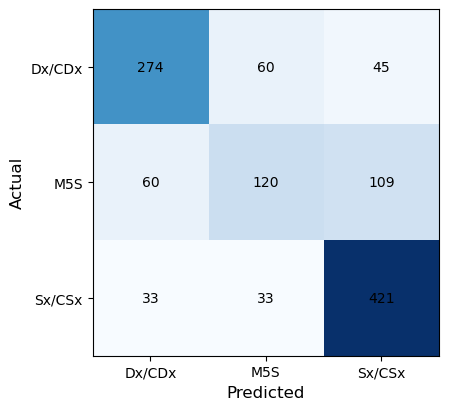

In [16]:
cm = confusion_matrix(y_test_enc, y_pred)
labels = ["Dx/CDx", "M5S", "Sx/CSx"]  # adjust if your LabelEncoder gives a different order

# -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 4.5))
im = ax.imshow(cm, cmap="Blues")

# numbers on cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                fontsize=10, color="black")

# axes
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

# colo

In [17]:
import shap
from sklearn.inspection import PartialDependenceDisplay

In [18]:
class_names = ['Dx/CDx', 'M5S', 'Sx/CSx']

In [19]:
model = final_lgbm   

In [20]:
explainer_tree = shap.TreeExplainer(model)
shap_values_tree = explainer_tree.shap_values(X_test)


In [21]:
def get_shaps(classifier, dataset):
    print(dataset.shape)
    explainer = shap.Explainer(classifier, dataset)
    shap_values = explainer(dataset,check_additivity=False)

    explainer_tree = shap.TreeExplainer(classifier)
    shap_values_tree = explainer_tree.shap_values(dataset)
    return shap_values,shap_values_tree

In [22]:
def plot_beeswarn(df,shap_values,filename,class_index=1):
    shap.summary_plot(shap_values[class_index], df,show=False,max_display=10,color='red',color_bar=True,class_names=True)
    fig = plt.gcf() # gcf means "get current figure"
    ax = plt.gca() #gca means "get current axes"

    fig.axes[1].yaxis.get_label().set_fontsize(22)
    # fig.axes[1].set_fontsize(24)
    plt.xlabel('SHAP value',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))

In [23]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test,check_additivity=False)

100%|===================| 3463/3465 [23:23<00:00]        

In [24]:
shap_values, shap_values_tree = get_shaps(model, X_test)

(1155, 93)


100%|===================| 3461/3465 [05:28<00:00]        

In [25]:
shap_values[:, :, 0]

.values =
array([[-0.1052686 ,  0.00014833,  0.05062776, ..., -0.06778568,
         0.07188837, -0.00311874],
       [ 0.04599927, -0.01380691,  0.02162167, ...,  0.11785967,
         0.01224803, -0.00222626],
       [-0.02947795,  0.00602702,  0.04738517, ...,  0.13414547,
         0.0368233 , -0.00085443],
       ...,
       [ 0.11193774,  0.00393897,  0.01309519, ..., -0.08386844,
        -0.03488114, -0.00139176],
       [-0.00510366,  0.00735206, -0.00381004, ...,  0.11391396,
         0.01005567, -0.00092765],
       [-0.02638614,  0.0157337 ,  0.04479977, ...,  0.11983465,
         0.02340904, -0.00390635]])

.base_values =
array([-2.18723592, -2.18723592, -2.18723592, ..., -2.18723592,
       -2.18723592, -2.18723592])

.data =
array([[55.,  0.,  2., ...,  1.,  0.,  0.],
       [33.,  1.,  3., ...,  0.,  0.,  0.],
       [49.,  0.,  2., ...,  0.,  0.,  0.],
       ...,
       [72.,  0.,  3., ...,  1.,  1.,  0.],
       [59.,  0.,  3., ...,  0.,  0.,  0.],
       [59.,  0.,  1.,

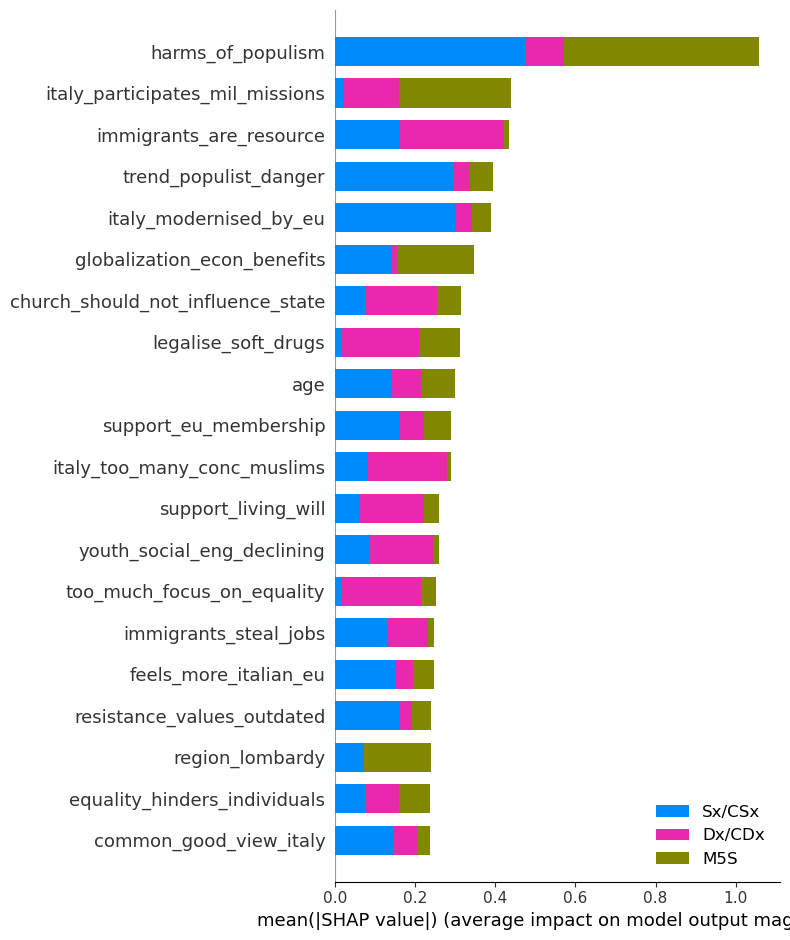

In [26]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names= class_names , feature_names = X_test.columns)

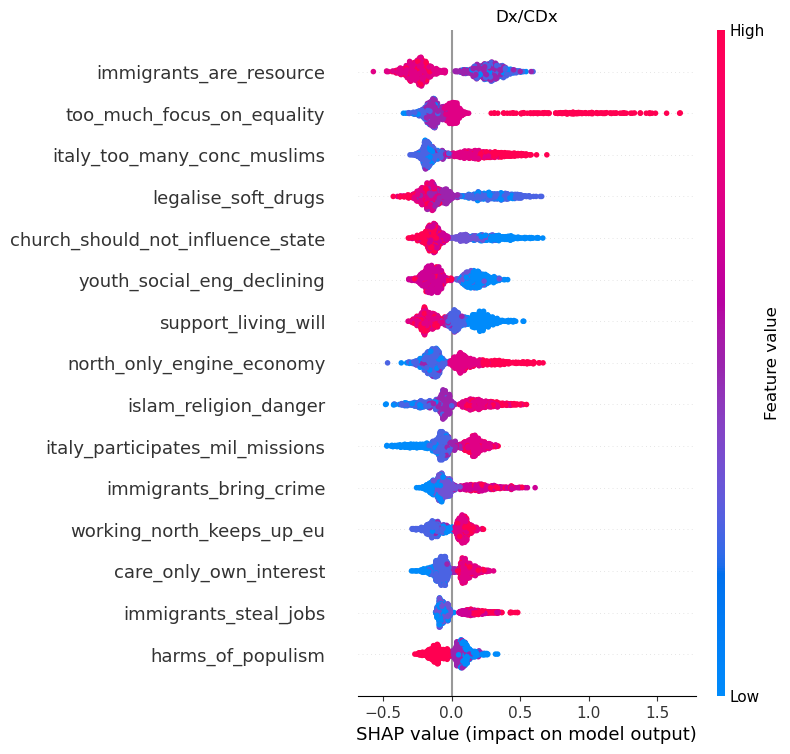

In [27]:
shap.summary_plot(shap_values[:, :, 0], X_test.values, feature_names = X_test.columns ,max_display=15, show=False)
plt.title("Dx/CDx")
plt.show()

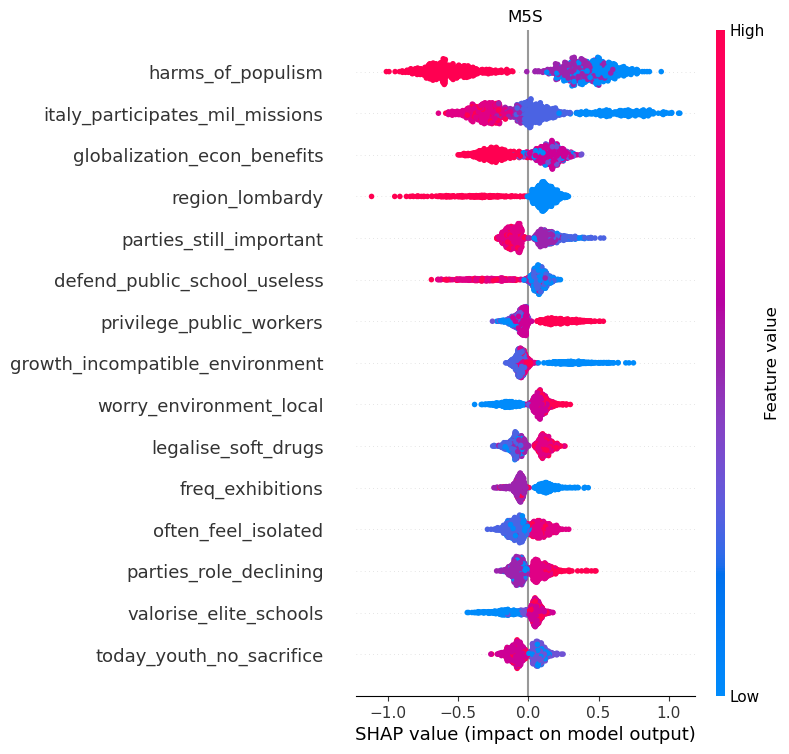

In [28]:
shap.summary_plot(shap_values[:, :, 1], X_test.values, feature_names = X_test.columns ,max_display=15, show=False)
plt.title("M5S")
plt.show()

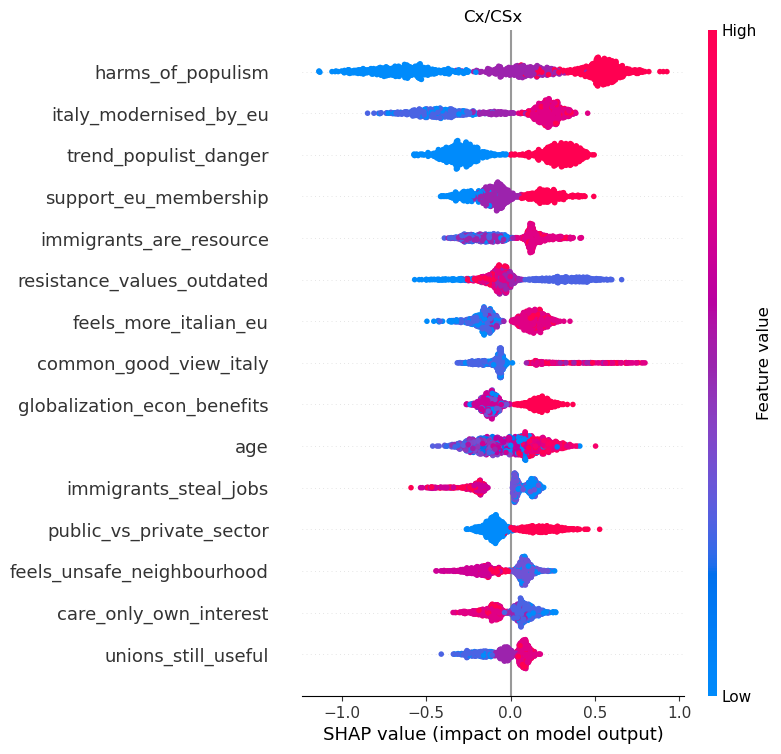

In [29]:
shap.summary_plot(shap_values[:, :, 2], X_test.values, feature_names = X_test.columns ,max_display=15, show=False)
plt.title("Cx/CSx")
plt.show()